# Using several classifiers and tuning parameters - Parameters grid
[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)

Adapted by Claudio Sartori

Example of usage of the ***model selection*** features of `scikit-learn` and comparison of several classification methods.
1. import a sample dataset 
1. do the usual preliminary data explorations and separate the predicting attributes from the *target* `'Exited'`
1. define the _models_ that will be tested and prepare the _hyperparameter ranges_ for the modules
1. set the list of *score functions* to choose from
1. split the dataset into two parts: train and test
1. Loop on score functions and, for each score, loop on the model labels (see details below)
    - optimize with GridSearchCV
    - test
    - store the results of best model
1. for each scoring show the best models for each classifier, sorted by decreasing performance
1. for each scoring show the confusion matrix of the prediction given by the best model

In [1]:
"""
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

print(__doc__) # print information included in the triple quotes at the beginning


@author: scikit-learn.org and Claudio Sartori



# 0. Initial settings
Set the random state and set the seed with `np.random.seed()`

Set the test set size and the number of cross valitadion splits

In [18]:
ts = 0.3 # test size
train_size = 1- ts #train size
random_state = 42
np.random.seed(random_state) # this sets the random sequence. Setting only this the repeatability is guaranteed
                             # only if we re-execute the entire notebook
cv = 3   # number of cross-validation splits

# 1. Import the dataset

In [4]:
df = pd.read_csv("churn-analysis.csv")
df.head(10)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,True
1,502,0,42,8,159660.80,3,1,0,113931.57,True
2,699,0,39,1,0.00,2,0,0,93826.63,False
3,822,1,50,7,0.00,2,1,1,10062.80,False
4,501,1,44,4,142051.07,2,0,1,74940.50,False
5,684,1,27,2,134603.88,1,1,1,71725.73,False
6,528,1,31,6,102016.72,2,0,0,80181.12,False
7,476,0,34,10,0.00,2,1,0,26260.98,False
8,549,0,25,5,0.00,2,0,0,190857.79,False
9,726,0,24,6,0.00,2,1,1,54724.03,False


# 2. Explore the data

The output of exploration is not shown here

In [11]:
df["Exited"].value_counts()
# df.groupby("Exited").count()

Exited
False    4204
True      810
Name: count, dtype: int64

In [13]:
# display here some exploration output
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      5014 non-null   int64  
 1   Gender           5014 non-null   int64  
 2   Age              5014 non-null   int64  
 3   Tenure           5014 non-null   int64  
 4   Balance          5014 non-null   float64
 5   NumOfProducts    5014 non-null   int64  
 6   HasCrCard        5014 non-null   int64  
 7   IsActiveMember   5014 non-null   int64  
 8   EstimatedSalary  5014 non-null   float64
 9   Exited           5014 non-null   bool   
dtypes: bool(1), float64(2), int64(7)
memory usage: 357.6 KB


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000,5014.000000
mean,649.668329,0.549063,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814
std,97.016799,0.497637,10.469459,2.888475,64133.565524,0.570347,0.455356,0.499769,57336.289016
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000
25%,582.000000,0.000000,31.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51399.190000
50%,653.000000,1.000000,37.000000,5.000000,62153.500000,1.000000,1.000000,1.000000,99132.310000
75%,717.000000,1.000000,43.000000,7.000000,121444.877500,2.000000,1.000000,1.000000,149295.360000
max,850.000000,1.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199929.170000


# 3. Define the _models_ 
Prepare the _hyperparameter ranges_ for the modules

Put everything in a dictionary, for ease of use

Please read carefully these data structures and understand them

It is also useful to read the API documentation of each classifier, in order to understand the hyperparameters

In [59]:
model_lbls = ['dt' # decision tree
             ,'nb' # gaussian naive bayes
             ,'lp'   # linear perceptron
      #        ,'svc'  # support vector # deactivate if running time becomes too long
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             ,'rf'   # random forest
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state), 
           'param': [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],                     
             },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(4,10)]
                     ,'n_estimators':[*range(10,60,10)]}]
          }

}

# 4. Set the list of *score functions* to choose from

In [15]:
scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

# 5. Split the dataset into the train and test parts
    - the *train* part will be used for training and cross-validation (i.e. for *development*)
    - the *test* part will be used for test (i.e. for *evaluation*)
    - the fraction of test data will be _ts_ (a value of your choice between 0.2 and 0.5)

In [19]:
target="Exited"
X = df.drop(target, axis=1)
X.head(6)

y = df[target]
y.head(6)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state= random_state, train_size = train_size)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

print(f"There are {Xtrain.shape[0]} samples in the training dataset")
print(f"There are {Xtest.shape[0]} samples in the test dataset")

print(f"Each sample has {Xtrain.shape[1]} features")

(3509, 9) (1505, 9) (3509,) (1505,)
There are 3509 samples in the training dataset
There are 1505 samples in the test dataset
Each sample has 9 features


# 6. Loop on scores and, for each score, loop on the model labels

The function `GridSearchCV` iterates a cross validation experiment to train and test a model with different combinations of paramater values
- for each parameter we have set before a list of values to test, `ParametersGrid` will be implicitly called to generate all the combinations
- we choose a *score function* which will be used for the optimization
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](https://scikit-learn.org/stable/modules/model_evaluation.html) for reference
- the output is a dataframe containing 
    - the set of parameters maximising the score 
    - the score used for optimisation and all the test scores

### Steps

- prepare an empty list `clfs` to store all the fitte models
- prepare an empty DataFrame which will collect the results of the fittings with each combination of parameters
    - dataframe columns are `'scoring','model','best_params','accuracy','precision_macro','recall_macro','f1_macro'`
- loop

In [91]:
clfs = []
y_preds = []
results = pd.DataFrame(columns=['scoring','model','best_params'#,'fit+score_time'
                                ,'accuracy','precision_macro','recall_macro','f1_macro'])
print(len(results))

for score in scores:
    print(f"SCORE: {score}")
    for model_lb in model_lbls:
        model = models.get(model_lb)
        md_name = model.get("name")
        md_params = model.get("param")
        md_estimator = model.get("estimator")
        
        print(f"Analysing Model: {md_name}")
        clf = GridSearchCV(md_estimator, param_grid=md_params, scoring=score, cv=cv)
        clf.fit(Xtrain, ytrain) 
        y_pred = clf.predict(Xtest)
        
        clfs.append(clf)
        y_preds.append(y_pred)
        cr = classification_report(y_true=ytest, y_pred=y_pred, output_dict=True)
        
        results.loc[len(results)] = [score, md_name, clf.best_params_, cr["accuracy"], cr["macro avg"]["precision"], cr["macro avg"]["recall"], cr["macro avg"]["f1-score"]] 

results
    

0
SCORE: accuracy
Analysing Model: Decision Tree       
Analysing Model: Gaussian Naive Bayes
Analysing Model: Linear Perceptron   
Analysing Model: K Nearest Neighbor 
Analysing Model: AdaBoost           
Analysing Model: Random forest       
SCORE: precision_macro
Analysing Model: Decision Tree       
Analysing Model: Gaussian Naive Bayes
Analysing Model: Linear Perceptron   
Analysing Model: K Nearest Neighbor 
Analysing Model: AdaBoost           
Analysing Model: Random forest       
SCORE: recall_macro
Analysing Model: Decision Tree       
Analysing Model: Gaussian Naive Bayes
Analysing Model: Linear Perceptron   
Analysing Model: K Nearest Neighbor 
Analysing Model: AdaBoost           
Analysing Model: Random forest       
SCORE: f1_macro
Analysing Model: Decision Tree       
Analysing Model: Gaussian Naive Bayes
Analysing Model: Linear Perceptron   
Analysing Model: K Nearest Neighbor 
Analysing Model: AdaBoost           
Analysing Model: Random forest       


,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
1,accuracy,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
2,accuracy,Linear Perceptron,"{'class_weight': None, 'early_stopping': True}",0.827243,0.413621,0.500000,0.452727
3,accuracy,K Nearest Neighbor,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974
4,accuracy,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 30}",0.879734,0.853044,0.685395,0.729258
5,accuracy,Random forest,"{'max_depth': 7, 'n_estimators': 30}",0.879070,0.877186,0.669779,0.715608
6,precision_macro,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
7,precision_macro,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
8,precision_macro,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping':...",0.174751,0.586551,0.501205,0.149963
9,precision_macro,K Nearest Neighbor,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


### Parameters to collect

`classification_report` produces a dictionary containing some classification performance measures, given the *ground truth* and the *predictions* (use the parameter `output_dict=True`)

The measures are (among others):
- `accuracy`
- `macro avg` a dictionary containing:
    - `precision`
    - `recall`
    - `f1-score`
- ...


### Loop

- repeat for all the chosen scorings
    - repeat for all the chosen classification models
        - store in `clf` the initialisation of `GridSearchCV` with the appropriate
            - classification model
            - parameters ranges
            - scoring
            - cross validation method `cv` (the same for all)
        - fit `clf` with the *train* part of `X` and `y`
        - store in `y_pred` the prediction for the *test* part of `X`
        - append `clf` to clfs`
        - append `y_pred` to `y_preds`
        - store in variable `cr` the `classification_report` produced with the test part of `y` and `y_pred`
        - store in the last row of `results` a list containing:
            - the name of the model
            - the `.best_params_` of `clf`
            - a selection of the contents of cr
                - 'accuracy', 
                - 'macro avg''precision'
                - 'macro avg''recall'
                - 'macro avg''f1-score'

Hints: 
- cr is a multi-level dictionary, second level can be reached 
with <br> `cr['first level label']['second level label']`
- to append a list as the last row of a dataframe you can use <br>
`df.loc[len(df)]=[]`

# 7. Display

For each scoring show the ranking of the models, and the confusion matrix given by the best model

For each scoring:
- set a `scoring_filter`
- filter the results of that scoring
- display the filtered dataframe with the `display()` function (it allows several displays of dataframes )



In [93]:
for score in scores:
    print(f"Results for scoring \"{score}\"")
    data = results.loc[results["scoring"] == score].drop(columns="scoring").sort_values(by=[score], ascending=False)
    display(data)
    

Results for scoring "accuracy"


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
4,AdaBoost,"{'learning_rate': 0.5, 'n_estimators': 30}",0.879734,0.853044,0.685395,0.729258
5,Random forest,"{'max_depth': 7, 'n_estimators': 30}",0.879070,0.877186,0.669779,0.715608
0,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
1,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
2,Linear Perceptron,"{'class_weight': None, 'early_stopping': True}",0.827243,0.413621,0.500000,0.452727
3,K Nearest Neighbor,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


Results for scoring "precision_macro"


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
11,Random forest,"{'max_depth': 4, 'n_estimators': 20}",0.871096,0.895666,0.636052,0.676715
10,AdaBoost,"{'learning_rate': 0.2, 'n_estimators': 20}",0.841860,0.881755,0.545351,0.540230
7,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
6,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
8,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping':...",0.174751,0.586551,0.501205,0.149963
9,K Nearest Neighbor,{'n_neighbors': 6},0.820598,0.525032,0.502070,0.464974


Results for scoring "recall_macro"


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
12,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 4}",0.724252,0.649313,0.743567,0.651403
16,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874419,0.811279,0.698919,0.734798
17,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880399,0.854085,0.687319,0.731352
13,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
15,K Nearest Neighbor,{'n_neighbors': 1},0.728239,0.523914,0.523842,0.523877
14,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping':...",0.260465,0.503507,0.502804,0.259208


Results for scoring "f1_macro"


,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
22,AdaBoost,"{'learning_rate': 1.25, 'n_estimators': 10}",0.874419,0.811279,0.698919,0.734798
18,Decision Tree,"{'class_weight': None, 'max_depth': 4}",0.871761,0.799722,0.700355,0.733511
23,Random forest,"{'max_depth': 9, 'n_estimators': 20}",0.880399,0.854085,0.687319,0.731352
19,Gaussian Naive Bayes,{'var_smoothing': 1e-12},0.849169,0.815833,0.583241,0.602023
21,K Nearest Neighbor,{'n_neighbors': 1},0.728239,0.523914,0.523842,0.523877
20,Linear Perceptron,"{'class_weight': 'balanced', 'early_stopping':...",0.260465,0.503507,0.502804,0.259208


# 8. Confusion matrices

Use the `ConfusionMatrixDisplay` with the best model of each scoring to compare the predictions

Repeat for every scoring:
- filter the results for the current scoring
- find the row with the best value of the scoring 
- display the confusion matrix with an appropriate title

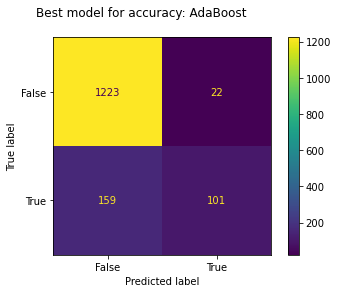

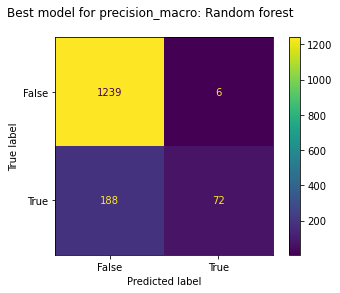

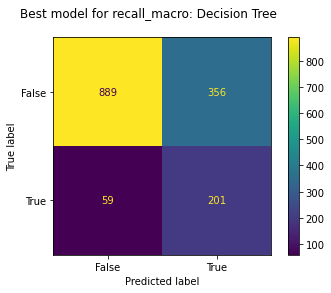

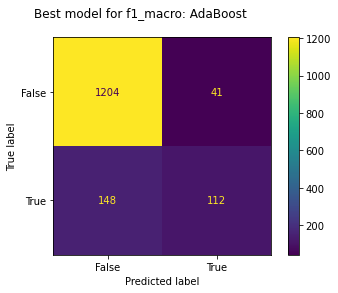

In [105]:
for score in scores:
    data = results.loc[results["scoring"] == score].drop(columns="scoring").sort_values(by=[score], ascending=False)
    best_value_row = data.iloc[0]
    ConfusionMatrixDisplay.from_estimator(clfs[best_value_row.name], Xtest, ytest)
    name = best_value_row["model"]
    plt.title(f"Best model for {score}: {name}\n ")
    plt.show()                                                               
